In [1]:
import numpy as np
import torch
import gym
from torch import nn
import matplotlib.pyplot as plt

In [2]:
# helper function to convert numpy arrays to tensors
def t(x): return torch.from_numpy(x).float()

The Actor Network is a simple network consisting of 3 densely connected layers with the LeakyReLU activation function. The network uses the Softmax activation function and the Categorical Cross Entropy loss function because the network outputs a probability distribution of actions.

In [3]:
# Actor module, categorical actions only
class Actor(nn.Module):
    def __init__(self, state_dim, n_actions):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(state_dim, 64),
            nn.Tanh(),
            nn.Linear(64, 32),
            nn.Tanh(),
            nn.Linear(32, n_actions),
            nn.Softmax()
        )
    
    def forward(self, X):
        return self.model(X)

Like the Actor Network, our Critic Network also consists of 3 densely connected layers with the LeakyReLU activation function. Because the output of the Critic Network is the TD Target, the network is optimized using the Mean Squared Error loss function.

In [4]:
# Critic module
class Critic(nn.Module):
    def __init__(self, state_dim):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(state_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )
    
    def forward(self, X):
        return self.model(X)

In [5]:
# Memory
# Stores results from the networks, instead of calculating the operations again from states, etc.
class Memory():
    def __init__(self):
        self.log_probs = []
        self.values = []
        self.rewards = []
        self.dones = []

    def add(self, log_prob, value, reward, done):
        self.log_probs.append(log_prob)
        self.values.append(value)
        self.rewards.append(reward)
        self.dones.append(done)
    
    def clear(self):
        self.log_probs.clear()
        self.values.clear()
        self.rewards.clear()
        self.dones.clear()  
    
    def _zip(self):
        return zip(self.log_probs,
                self.values,
                self.rewards,
                self.dones)
    
    def __iter__(self):
        for data in self._zip():
            return data
    
    def reversed(self):
        for data in list(self._zip())[::-1]:
            yield data
    
    def __len__(self):
        return len(self.rewards)
        

In [6]:
env = gym.make("CartPole-v1",new_step_api=True)

TypeError: __init__() got an unexpected keyword argument 'new_step_api'

torch.optim:https://pytorch.org/docs/stable/optim.html

In [ ]:
# config
state_dim = env.observation_space.shape[0]
n_actions = env.action_space.n
actor = Actor(state_dim, n_actions)
critic = Critic(state_dim)
adam_actor = torch.optim.Adam(actor.parameters(), lr=1e-3)
adam_critic = torch.optim.Adam(critic.parameters(), lr=1e-3)
gamma = 0.99
memory = Memory()
max_steps = 100

When initializing optimizer you explicitly tell it what parameters (tensors) of the model it should be updating. The gradients are "stored" by the tensors themselves (they have a grad and a requires_grad attributes) once you call backward() on the loss. After computing the gradients for all tensors in the model, calling optimizer.step() makes the optimizer iterate over all parameters (tensors) it is supposed to update and use their internally stored grad to update their values.

In [ ]:
# train function
def train(memory, q_val):
    values = torch.stack(memory.values)
    q_vals = np.zeros((len(memory), 1))
    
    # target values are calculated backward
    # it's super important to handle correctly done states,
    # for those cases we want our to target to be equal to the reward only
    for i, (_, _, reward, done) in enumerate(memory.reversed()):
        q_val = reward + gamma*q_val*(1.0-done)
        q_vals[len(memory)-1 - i] = q_val # store values from the end to the beginning
        
    advantage = torch.Tensor(q_vals) - values
    
    #Critic loss
    #The critic basically tries to apply MSE between TD target and current state value, as we already have the difference on the advantage
    critic_loss = advantage.pow(2).mean()

    #zero_grad() restarts looping without losses from the last step if you use the gradient method for decreasing the error (or losses).
    #If you do not use zero_grad() the loss will increase not decrease as required.
    adam_critic.zero_grad()
    critic_loss.backward()
    adam_critic.step()
    
    #Actor loss
    #For the actor (in the case of categorical actions) we sample from a categorical distribution then calculate the loss like usually do for probabilities, 
    #that is using the negative log likelihood, scaled by the advantage
    actor_loss = (-torch.stack(memory.log_probs)*advantage.detach()).mean()

    adam_actor.zero_grad()
    actor_loss.backward()
    adam_actor.step()

In [ ]:
episode_rewards = []

for i in range(500):
    done = False
    total_reward = 0
    state = env.reset()
    steps = 0

    while not done:
        probs = actor(t(state))
        dist = torch.distributions.Categorical(probs=probs)
        action = dist.sample()
        
        next_state, reward, done, terminated, info = env.step(action.detach().data.numpy())
        
        total_reward += reward
        steps += 1
        memory.add(dist.log_prob(action), critic(t(state)), reward, done)
        
        state = next_state
        
        # train if done or num steps > max_steps
        if done or (steps % max_steps == 0):
            last_q_val = critic(t(next_state)).detach().data.numpy()
            train(memory, last_q_val)
            memory.clear()
            
    episode_rewards.append(total_reward)

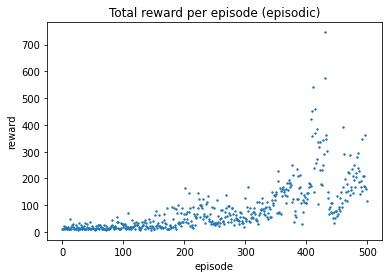

In [ ]:
plt.scatter(np.arange(len(episode_rewards)), episode_rewards, s=2)
plt.title("Total reward per episode (episodic)")
plt.ylabel("reward")
plt.xlabel("episode")
plt.show()